In [157]:
#import trainer
#import data_loader

import tensorflow as tf
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab

In [42]:
class DataLoader():
    def __init__(self, train_path, test_path):
        self.train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
        self.test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

    def load_data(self, num_words=10000):
        tokenizer = Mecab()
        stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
        self.train_data.drop_duplicates(subset=['document'], inplace=True)
        self.train_data = self.train_data.dropna(how='any')
        self.test_data.drop_duplicates(subset=['document'], inplace=True)
        self.test_data = self.test_data.dropna(how='any')

        X_train = []
        for sentence in self.train_data['document']:
            temp_X = tokenizer.morphs(sentence)  # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
            X_train.append(temp_X)

        X_test = []
        for sentence in self.test_data['document']:
            temp_X = tokenizer.morphs(sentence)  # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
            X_test.append(temp_X)

        words = np.concatenate(X_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(num_words - 4)
        vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
        self.word_to_index = {word: index for index, word in enumerate(vocab)}

        def wordlist_to_indexlist(wordlist):
            return [self.word_to_index[word] if word in self.word_to_index else self.word_to_index['<UNK>'] for word in wordlist]

        self.X_train = list(map(wordlist_to_indexlist, X_train))
        self.X_test = list(map(wordlist_to_indexlist, X_test))
        self.Y_train = np.array(list(self.train_data['label']))
        self.Y_test = np.array(list(self.test_data['label']))
        #return self.X_train, self.Y_train, self.X_test, self.Y_test, self.word_to_index

    def get_maxlen(self):
        total_data_text = list(self.X_train) + list(self.X_test)
        # 텍스트데이터 문장길이의 리스트를 생성한 후
        num_tokens = [len(tokens) for tokens in total_data_text]
        num_tokens = np.array(num_tokens)
        # 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
        print('문장길이 평균 : ', np.mean(num_tokens))
        print('문장길이 최대 : ', np.max(num_tokens))
        print('문장길이 표준편차 : ', np.std(num_tokens))

        # 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
        max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
        self.maxlen = int(max_tokens)
        print('pad_sequences maxlen : ', self.maxlen)
        print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))
        return self.maxlen

    def set_pad(self, padding='post'):
        self.X_train = keras.preprocessing.sequence.pad_sequences(self.X_train,
                                                             value=self.word_to_index["<PAD>"],
                                                             padding='post',  # 혹은 'pre'
                                                             maxlen=self.maxlen)

        self.X_test = keras.preprocessing.sequence.pad_sequences(self.X_test,
                                                            value=self.word_to_index["<PAD>"],
                                                            padding='post',  # 혹은 'pre'
                                                            maxlen=self.maxlen)
        return self.X_train, self.X_test

    def get_data(self, train_idx=30000):
        x_train = self.X_train[:train_idx]
        x_val = self.X_train[train_idx:]

        y_train = self.Y_train[:train_idx]
        y_val = self.Y_train[train_idx:]

        return x_train, y_train, x_val, y_val, self.X_test, self.Y_test

In [43]:
from sklearn.model_selection import train_test_split

class Trainer():
    def data_split(self, src_data, tgt_data,  val_size = 0.2, test_size = 0.2):
        x_data, self.test_x, y_data, self.test_y = train_test_split(src_data, tgt_data, test_size=test_size)
        self.train_x, self.val_x, self.train_y, self.val_y = train_test_split(x_data, y_data, test_size=val_size)

    def train(self, model, optimizer, loss, epochs=100, batch_size=512, verbose=2):
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        self.hist = model.fit(self.train_x, self.train_y, epochs=epochs, batch_size=batch_size, validation_data=(self.val_x, self.val_y), verbose=verbose)

    def test(self, model):
        test_loss, test_acc = model.evaluate(self.test_x, self.test_y)
        print("test_loss    :{}".format(test_loss))
        print("test_accuracy:{}".format(test_acc))

    def visualization(self):
        history_dict = self.hist.history
        
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 8))

        # loss 그래프
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # accuracy 그래프
        plt.subplot(1, 2, 2)
        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

In [44]:
train_path = '~/aiffel/sentiment_classification/data/ratings_train.txt'
test_path = '~/aiffel/sentiment_classification/data/ratings_test.txt'

In [45]:
data_loader = DataLoader(train_path, test_path)

In [173]:
data_loader.load_data(10000)
data_loader.get_maxlen()
data_loader.set_pad('post')
x_train, y_train , x_val, y_val, x_test, y_test = data_loader.get_data(train_idx=130000)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [47]:
trainer = Trainer()

In [174]:
trainer.train_x = x_train
trainer.val_x = x_val
trainer.test_x = x_test
trainer.train_y = y_train
trainer.val_y = y_val
trainer.test_y = y_test

In [175]:
print(x_train.shape)
print(x_train[0])
print(x_train[0].shape)
#print(keras.layers.Input(shape=(41,)))
#print(keras.layers.Embedding(100, 25)(x_train).shape)

(130000, 41)
[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
(41,)


In [86]:
x = keras.layers.Embedding(10001, 24)(x_train)
x.shape[2]

24

In [121]:
x_train[4]

array([   2, 8894, 1108,   52, 2832,   60,    5,   14, 2758,   41, 1188,
         35,  351,   42,   22,   40,   60,    2,    2,  427, 3102, 1766,
          6,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

# Base Model
LSTM Model

In [49]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 25

lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
lstm_model.add(keras.layers.LSTM(256, activation = 'relu'))
lstm_model.add(keras.layers.Dense(256, activation='relu'))
lstm_model.add(keras.layers.Dense(128, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 25)          250000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               288768    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 637,585
Trainable params: 637,585
Non-trainable params: 0
_________________________________________________________________


In [50]:
trainer.train(model=lstm_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
59/59 - 12s - loss: 0.6907 - accuracy: 0.5182 - val_loss: 0.6925 - val_accuracy: 0.5173
Epoch 2/10
59/59 - 10s - loss: 0.5721 - accuracy: 0.7151 - val_loss: 36.8145 - val_accuracy: 0.8052
Epoch 3/10
59/59 - 10s - loss: 0.3819 - accuracy: 0.8427 - val_loss: 0.7106 - val_accuracy: 0.8241
Epoch 4/10
59/59 - 10s - loss: 0.3021 - accuracy: 0.8794 - val_loss: 0.4515 - val_accuracy: 0.8273
Epoch 5/10
59/59 - 10s - loss: 0.2599 - accuracy: 0.9006 - val_loss: 0.4437 - val_accuracy: 0.8224
Epoch 6/10
59/59 - 10s - loss: 0.2341 - accuracy: 0.9138 - val_loss: 0.5034 - val_accuracy: 0.8191
Epoch 7/10
59/59 - 10s - loss: 0.2200 - accuracy: 0.9209 - val_loss: 0.4714 - val_accuracy: 0.8167
Epoch 8/10
59/59 - 10s - loss: 0.2075 - accuracy: 0.9266 - val_loss: 0.5603 - val_accuracy: 0.8123
Epoch 9/10
59/59 - 10s - loss: 0.1888 - accuracy: 0.9343 - val_loss: 0.5203 - val_accuracy: 0.8114
Epoch 10/10
59/59 - 10s - loss: 0.1763 - accuracy: 0.9396 - val_loss: 0.5406 - val_accuracy: 0.8047


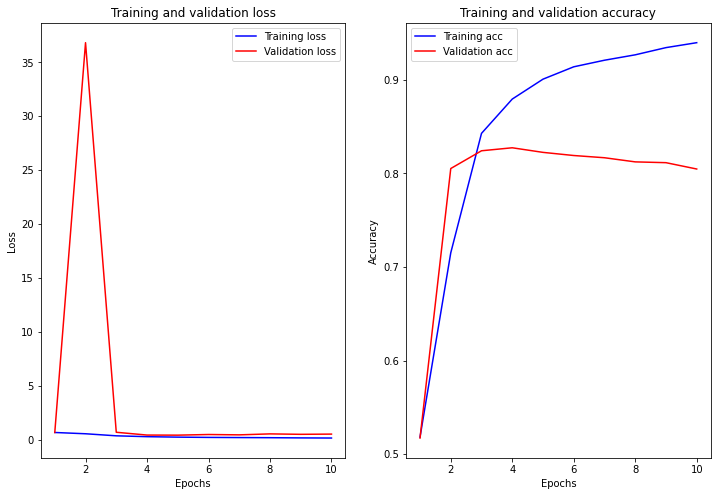

1537/1537 [==============================] - 13s 9ms/step - loss: 0.5399 - accuracy: 0.8044
test_loss    :0.5399380326271057
test_accuracy:0.8043819069862366


In [51]:
trainer.visualization()
trainer.test(lstm_model)

# Attention model

In [52]:
input_dim = 41

# input layer
inputs = keras.layers.Input(shape=(input_dim,))

# attention layer
attention_probs = keras.layers.Dense(input_dim, activation='softmax')(inputs)
attention_mul = keras.layers.multiply([inputs, attention_probs])

# fc layer
fc = keras.layers.Dense(64)(attention_mul)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

attention_model = keras.Model(inputs=[inputs], outputs=output)

attention_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 41)           1722        input_6[0][0]                    
__________________________________________________________________________________________________
multiply_5 (Multiply)           (None, 41)           0           input_6[0][0]                    
                                                                 dense_25[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 64)           2688        multiply_5[0][0]           

In [53]:
trainer.train(model=attention_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
59/59 - 1s - loss: 3.8383 - accuracy: 0.5007 - val_loss: 1.1788 - val_accuracy: 0.5031
Epoch 2/10
59/59 - 0s - loss: 1.1680 - accuracy: 0.5035 - val_loss: 0.9787 - val_accuracy: 0.5025
Epoch 3/10
59/59 - 0s - loss: 1.0275 - accuracy: 0.5000 - val_loss: 1.0376 - val_accuracy: 0.5035
Epoch 4/10
59/59 - 0s - loss: 1.0459 - accuracy: 0.4965 - val_loss: 1.0164 - val_accuracy: 0.5037
Epoch 5/10
59/59 - 0s - loss: 0.9398 - accuracy: 0.5031 - val_loss: 0.9868 - val_accuracy: 0.5033
Epoch 6/10
59/59 - 0s - loss: 0.9504 - accuracy: 0.5015 - val_loss: 0.9800 - val_accuracy: 0.4987
Epoch 7/10
59/59 - 0s - loss: 1.0979 - accuracy: 0.5032 - val_loss: 1.0557 - val_accuracy: 0.5025
Epoch 8/10
59/59 - 0s - loss: 0.9490 - accuracy: 0.5031 - val_loss: 1.0135 - val_accuracy: 0.5046
Epoch 9/10
59/59 - 0s - loss: 0.9460 - accuracy: 0.4975 - val_loss: 0.9398 - val_accuracy: 0.4984
Epoch 10/10
59/59 - 0s - loss: 0.9579 - accuracy: 0.4963 - val_loss: 0.8848 - val_accuracy: 0.5010


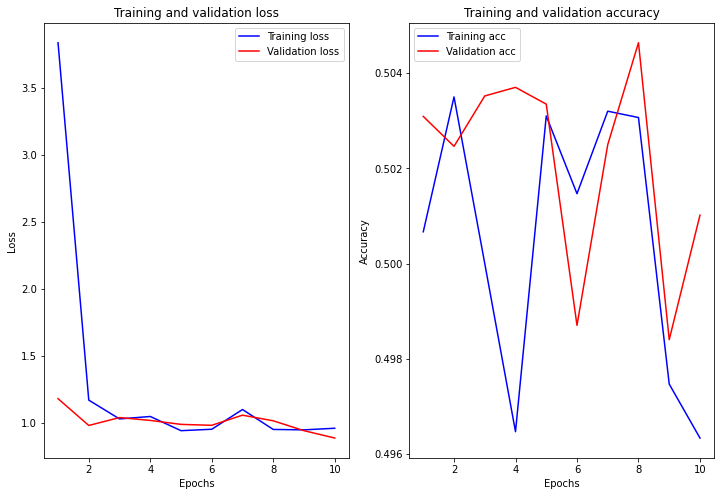

In [54]:
trainer.visualization()

In [55]:
trainer.test(attention_model)


1537/1537 [==============================] - 3s 2ms/step - loss: 0.8821 - accuracy: 0.5062
test_loss    :0.8821205496788025
test_accuracy:0.5062147974967957


# Attention with LSTM model

In [63]:
vocab_size = 10000   
word_vector_dim = 25
input_dim = 41

# input layer
inputs = keras.layers.Input(shape=(input_dim,))

# attention layer
attention_probs = keras.layers.Dense(input_dim, activation='softmax')(inputs)
attention_mul = keras.layers.multiply([inputs, attention_probs])

embed_layer = keras.layers.Embedding(vocab_size, word_vector_dim)(attention_mul)

# lstm layer
lstm_layer = keras.layers.LSTM(256, activation='relu')(embed_layer)

# fc layer
fc = keras.layers.Dense(64)(lstm_layer)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

attention_lstm_model = keras.Model(inputs=[inputs], outputs=output)

attention_lstm_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 41)           1722        input_11[0][0]                   
__________________________________________________________________________________________________
multiply_10 (Multiply)          (None, 41)           0           input_11[0][0]                   
                                                                 dense_38[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 41, 25)       250000      multiply_10[0][0]          

In [60]:
trainer.train(model=attention_lstm_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
59/59 - 12s - loss: 0.6933 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 2/10
59/59 - 10s - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 3/10
59/59 - 10s - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 4/10
59/59 - 10s - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 5/10
59/59 - 10s - loss: 0.6942 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 6/10
59/59 - 10s - loss: 0.6928 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 7/10
59/59 - 10s - loss: 0.6936 - accuracy: 0.5049 - val_loss: 0.6933 - val_accuracy: 0.5022
Epoch 8/10
59/59 - 10s - loss: 0.6924 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 9/10
59/59 - 10s - loss: 0.6921 - accuracy: 0.5041 - val_loss: 0.6932 - val_accuracy: 0.5021
Epoch 10/10
59/59 - 10s - loss: 0.8330 - accuracy: 0.5093 - val_loss: 0.6931 - val_accuracy: 0.5015


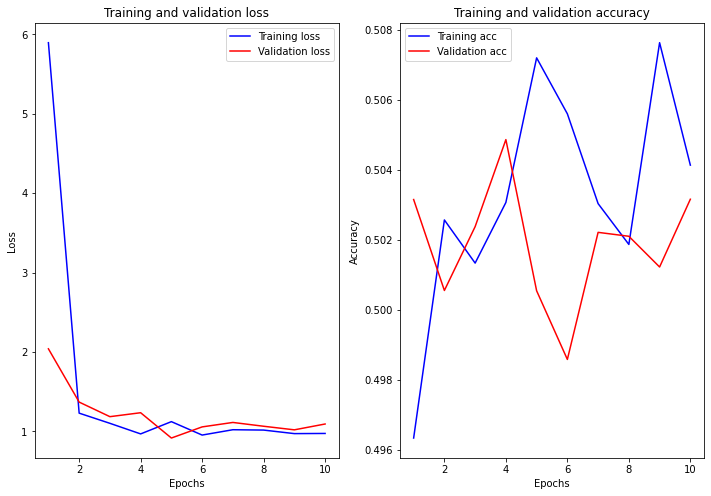

1537/1537 [==============================] - 3s 2ms/step - loss: 1.0901 - accuracy: 0.5086
test_loss    :1.0901055335998535
test_accuracy:0.508615255355835


In [58]:
trainer.visualization()
trainer.test(attention_model)

# Attention 3D

In [89]:
vocab_size = 10000   
word_vector_dim = 25
time_steps = 41

# input layer
inputs = keras.layers.Input(shape=(time_steps,))

embed = keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)

# attention layer
# inputs.shape = (batch_size, time_steps, input_dim)
input_dim = int(embed.shape[2])

a = keras.layers.Permute((2, 1))(embed) # same transpose
#a = tf.keras.layers.Reshape((input_dim, TIME_STEPS))(a) 
# this line is not useful. It's just to know which dimension is what.
a = keras.layers.Dense(time_steps, activation='softmax')(a)
a_probs = keras.layers.Permute((2, 1), name='attention_vec')(a)
output_attention_mul  = keras.layers.multiply([embed, a_probs])


# lstm layer
lstm_out = keras.layers.LSTM(256, activation='relu')(output_attention_mul)

# fc layer
fc = keras.layers.Dense(64)(lstm_out)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

attention_3d_model = keras.Model(inputs=[inputs], outputs=output)

attention_3d_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 41, 25)       250000      input_15[0][0]                   
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 25, 41)       0           embedding_32[0][0]               
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 25, 41)       1722        permute_2[0][0]                  
___________________________________________________________________________________________

In [90]:
trainer.train(model=attention_3d_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)
trainer.test(attention_3d_model)

Epoch 1/10
59/59 - 14s - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 2/10
59/59 - 12s - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 3/10
59/59 - 12s - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 4/10
59/59 - 11s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 5/10
59/59 - 11s - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 6/10
59/59 - 11s - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 7/10
59/59 - 11s - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 8/10
59/59 - 11s - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 9/10
59/59 - 11s - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.4985
Epoch 10/10
59/59 - 11s - loss: 0.6931 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5015
1537/1537

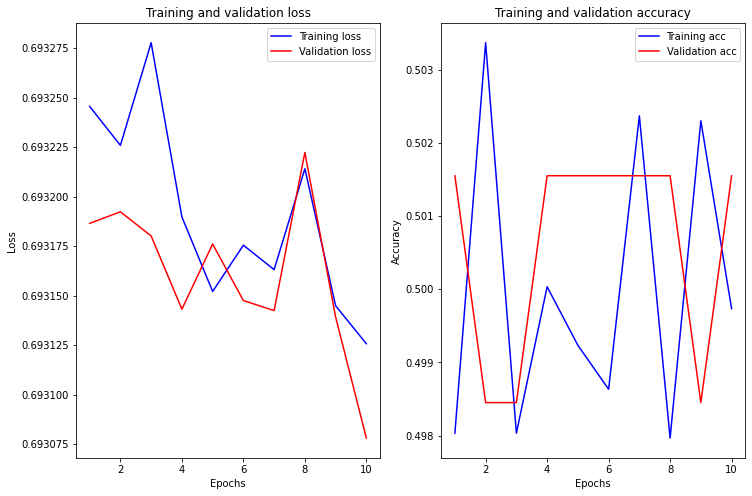

In [92]:
trainer.visualization()

In [124]:
def view_attention_vector(model, test_x):
	layer_outputs    = [layer.output for layer in model.layers if layer.name == 'attention_vec']
	activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
	output_data = activation_model.predict(test_x)
	output_data = keras.layers.Permute((2, 1))(output_data)
	print(output_data[4].shape)
	attention_vector = np.mean(output_data[4], axis=0)
	df = pd.DataFrame(attention_vector.transpose(), columns=['attention (%)'])
	df.plot.bar()

(25, 41)


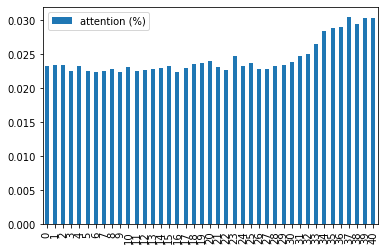

In [125]:
view_attention_vector(attention_3d_model, x_test)

# Transformer

In [158]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = keras.layers.Dense(embedding_dim)
        self.key_dense = keras.layers.Dense(embedding_dim)
        self.value_dense = keras.layers.Dense(embedding_dim)
        self.dense = keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [159]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(dff, activation="relu"),
             keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [160]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = range(0, max_len, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [178]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기
vocab_size = 10000
max_len = 41

inputs = keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(20, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

transformer = keras.Model(inputs=inputs, outputs=outputs)
transformer.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
token_and_position_embedding (None, 41, 32)            321312    
_________________________________________________________________
transformer_block_7 (Transfo (None, 41, 32)            6464      
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 20)                660       
_________________________________________________________________
dropout_27 (Dropout)         (None, 20)                0  

In [179]:
trainer.train(model=transformer, optimizer='adam', loss='binary_crossentropy', epochs=5, verbose=2)

Epoch 1/5
254/254 - 7s - loss: 0.4633 - accuracy: 0.7726 - val_loss: 0.3523 - val_accuracy: 0.8450
Epoch 2/5
254/254 - 5s - loss: 0.3393 - accuracy: 0.8550 - val_loss: 0.3486 - val_accuracy: 0.8475
Epoch 3/5
254/254 - 5s - loss: 0.3221 - accuracy: 0.8618 - val_loss: 0.3474 - val_accuracy: 0.8468
Epoch 4/5
254/254 - 5s - loss: 0.3072 - accuracy: 0.8661 - val_loss: 0.3521 - val_accuracy: 0.8469
Epoch 5/5
254/254 - 5s - loss: 0.2924 - accuracy: 0.8693 - val_loss: 0.3597 - val_accuracy: 0.8440


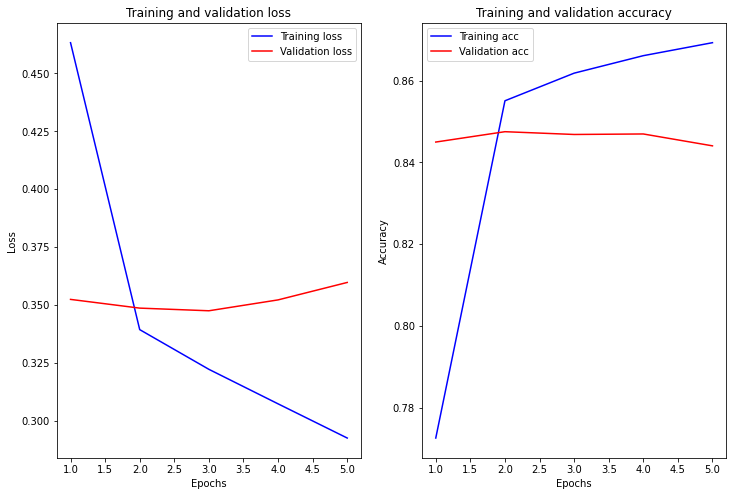

1537/1537 [==============================] - 6s 4ms/step - loss: 0.3635 - accuracy: 0.8440
test_loss    :0.3634662926197052
test_accuracy:0.8439693450927734


In [180]:
trainer.visualization()
trainer.test(transformer)

# Self Attention

In [ ]:
from keras_self_attention import SeqSelfAttention

embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기
vocab_size = 10000
max_len = 41

In [ ]:
SelfAttention  = keras.Sequential()
SelfAttention.add(keras.layer.Embedding(vocab_size, embedding_dim, input_length=max_len))
SelfAttention.add(keras.layer.LSTM(256, activation='relu'))
SelfAttention.add(SeqSelfAttention(attention_activation='sigmoid'))
SelfAttention.add(keras.layer.Dense(1, activation='sigmoid'))

SelfAttention.summary()